# Choosing hyperparameters for deep learning via GridSearch
`by Dr. James G. Shanahan`

## Goals of this notebook:

- How to use Keras models in scikit-learn.
- How to use grid search in scikit-learn.
* Hyperparamters that can be tuned for Keras models via grid search (and or crossfold validation):
  * tune batch size and training epochs.
  - optimization algorithms.
  - learning rate and momentum.
  - network weight initialization.
  - activation functions.
  - dropout regularization.
  - the number of neurons in the hidden layer.


# Use Keras with hyperparmeters 
Keras models can leverage scikit-learn ML framework (has various tools such as gridsearch, crossfoldvalidation, metrics, etc) by wrapping themselves with the `KerasClassifier` or `KerasRegressor` wrapper classes. To use these wrappers you must following steps 
1.  **A Keras model creation function**: define a function that creates and returns a Keras sequential model (this may change to include the models create via the Keras functional API; see latest documentation for updates on this front)
*  **Create an instance of the wrapper functions, e.g.,KerasClassifier**: then pass `keras sequential model` function to the `build_fn argument` when constructing the `KerasClassifier` class. 

An example of this is included here:


```python
# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_NN_model(optimizer='adagrad',
                 kernel_initializer='glorot_uniform', 
                 dropout=0.2):
    
    model = Sequential()
    model.add(Dense(10,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model

# wrap the model using the function we created
neuralNetworkModel = KerasRegressor(build_fn=create_NN_model,verbose=0)
    
pipeline = Pipeline([
    ('preprocess',scaler),
    ('neuralNetworkModel',neuralNetworkModel)
])
  
```



The constructor for the `KerasClassifier class` can take default arguments that are passed on to the calls to model.fit(), such as the number of epochs and the batch size.

For example:

``` python
def create_NN_model():
	...
	return model

model = KerasClassifier(build_fn=create_NN_model, epochs=10)
```

The constructor for the KerasClassifier class can also take new arguments that can be passed to your custom create_model() function. These new arguments must also be defined in the signature of your create_model() function with default parameters.

For example:

```python
def create_NN_model(dropout_rate=0.0):
	...
	return model

model = KerasClassifier(build_fn=create_NN_model, dropout_rate=0.2)
```

You can learn more about the scikit-learn wrapper in [Keras API documentation](http://keras.io/scikit-learn-api/).

## Hyperparmeter Tuning

Hyper-parameters are parameters that are not directly learnt during model learning phase. In scikit-learn they are passed as arguments to the constructor of the model/estimator classes. Typical examples include number of epochs, C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.

It is possible and recommended to search the hyper-parameter space for hyperparameter combination the yields the the best cross validation score using the SKLearn GridSearchCV class. For more details on SKLearn  `GridSearchCV` click [here](https://scikit-learn.org/stable/modules/grid_search.html).

Any parameter provided when constructing an model may be optimized in this manner.  The GridSearchCV process will then construct and evaluate one model for each combination of parameters. Cross validation is used to evaluate each individual model.

Grid search, model hyperparameter optimization technique, can be accomplishe via scikit-learn via the GridSearchCV class. When constructing this class one must provide a dictionary of hyperparameters to evaluate in the `param_grid` argument. This is a map of the model parameter name and a corresponding array of values to try. By default, `accuracy` is the score that is optimized, but other scores can be specified in the score argument of the GridSearchCV constructor.

By default, the grid search will only use one thread. By setting the `n_jobs` argument in the GridSearchCV constructor to `-1`, the process will use all cores on your machine. Depending on your Keras backend, this may interfere with the main neural network training process.

The GridSearchCV process will then construct and evaluate one model for each combination of parameters. Cross validation is used to evaluate each individual model and the default of n-fold cross validation is used, although this can be overridden by specifying the cv argument to the GridSearchCV constructor.


Grid Search CV Parameters:

1. **Batch Size and Epochs**: The batch size in iterative gradient descent is the number of patterns shown to the network before the weights are updated. The number of epochs is the number of times that the entire training dataset is shown to the network during training.

2. **Optimizer**: tune the optimization algorithm used to train the network

3. **Learning Rate**: Learning rate controls how much to update the weight at the end of each batch

4. **Kernel Initializer**: network weight initialization

5. **Neural Activation**: The activation function controls the non-linearity of individual neurons and when to fire.

6. **Dropout**: Tuning the dropout rate for regularization in an effort to limit overfitting and improve the model’s ability to generalize.

7. **No. of Neurons**: The number of neurons in a layer is an important parameter to tune. A larger network requires more training and at least the batch size and number of epochs should ideally be optimized with the number of neurons.

Please refer to the following link for more details:
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


# Generate a small 2D classification dataset

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from sklearn.datasets import make_regression,make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier  

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True


Using TensorFlow backend.


In [2]:
def generateData():
    #Generate a random n-class classification problem.
    X, y = make_classification(n_samples=100,n_features=2, n_redundant=0,n_informative=2)
    return X,y

In [3]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


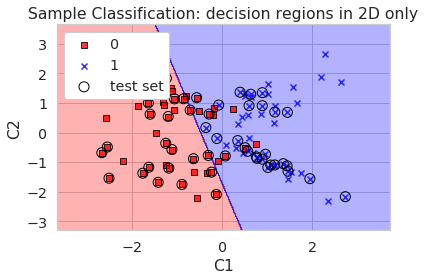

In [11]:
from sklearn.linear_model import Perceptron

def analyzeData(X, y):   
    ppn = Perceptron(max_iter=40, eta0=0.1, random_state=1)
    ppn.fit(X, y)

    plot_decision_regions(X=X, y=y,
                          classifier=ppn, test_idx=range(50, 100))
    plt.title('Sample Classification: decision regions in 2D only')
    plt.xlabel('C1')
    plt.ylabel('C2')
    plt.legend(loc='upper left')

    plt.tight_layout()
    #plt.savefig('images/03_01.png', dpi=300)
    plt.show()

X, y  = generateData()

analyzeData(X, y)


# Hyperparameter optimization via GridSearch

In [12]:
# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(optimizer='adagrad',
                 kernel_initializer='glorot_uniform', 
                 dropout=0.2):
    
    model = Sequential()
    model.add(Dense(10,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
config = {"units": 100, 
          "activation": "relu", 
          "kernel_initializer": "he_normal"}

feature_layers = [
    Dense(**config, input_shape=(X_train.shape[1],)), 
    Dense(**config), 
    Dense(**config), 
    Dense(**config), 
    Dense(**config)
]

extractor_len = len(feature_layers)

And only one layer as a classifier

classification_layers = [
    Dense(units=5, activation="softmax")
]

#Build model

model = Sequential(layers=feature_layers + classification_layers)

In [15]:
def mainDriver(X, y, pipeline, param_grid):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        
    grid = GridSearchCV(pipeline, cv=3, param_grid=param_grid, n_jobs=-1)
    grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    params = grid.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

# Todo
# print out best hyperparemter combo 
#


# add experiment table


#end def

### Grid search for Deep Learning hyperparameters (model, learning algorithm)

When training deep models:

Grid search for Deep Learning hyperparameters
1. Model spec
  * number of layers, 
  * type of activation functions
  * number of neurons
  * regularization (dropout, maxout, L1, L2)
  * initialization (Glorot, random uniform)
* training algorithm spec
  * Which flavor of GD (RMSProp, ADAM, NADAM)?
  * Number of epochs
  * learning rates
  * early stopping
  * batch size

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.7 µs


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


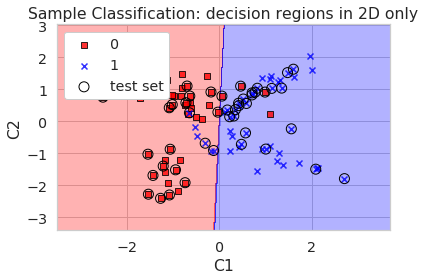

Epoch 1/6
67/67 [==============================] - 22s 333ms/step - loss: 0.6925 - acc: 0.6418
Epoch 2/6
67/67 [==============================] - 0s 503us/step - loss: 0.6904 - acc: 0.7164
Epoch 3/6
67/67 [==============================] - 0s 730us/step - loss: 0.6884 - acc: 0.7910
Epoch 4/6
67/67 [==============================] - 0s 701us/step - loss: 0.6865 - acc: 0.7463
Epoch 5/6
67/67 [==============================] - 0s 632us/step - loss: 0.6840 - acc: 0.8806
Epoch 6/6
67/67 [==============================] - 0s 702us/step - loss: 0.6821 - acc: 0.8358
Best: -0.683343 using {'nn__batch_size': 10, 'nn__dropout': 0.1, 'nn__epochs': 6, 'nn__kernel_initializer': 'normal', 'nn__optimizer': 'rmsprop'}
-0.687969 (0.001906) with: {'nn__batch_size': 10, 'nn__dropout': 0.1, 'nn__epochs': 4, 'nn__kernel_initializer': 'uniform', 'nn__optimizer': 'rmsprop'}
-0.690787 (0.000692) with: {'nn__batch_size': 10, 'nn__dropout': 0.1, 'nn__epochs': 4, 'nn__kernel_initializer': 'uniform', 'nn__optimize

In [14]:
%time
X, y  = generateData()

analyzeData(X, y)
    
# create parameter grid with various hyperparameters
# prefixed by model name: clf__
#turn on/off the needed parameters
param_grid = {
    'nn__batch_size': [10, 20],
    'nn__epochs':[4,6],
    'nn__optimizer':['rmsprop','adam',],
    #'nn__learn_rate' : [0.001, 0.01, 0.1, 0.2, 0.3],
    'nn__kernel_initializer':['uniform','normal'],
    #'nn__activation' : ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    'nn__dropout':[0.1,0.2]
    ##'nn__neuronsPerLayer' : [[ 5, 10, 15, 20, 25, 30],[ 25, 30]]      
}

scaler = StandardScaler()   

# wrap the model using the function we created
neuralNetworkModel = KerasRegressor(build_fn=create_model,verbose=1)
    
pipeline = Pipeline([
    ('preprocess',scaler),
    ('nn',neuralNetworkModel)
])
    
if __name__ == '__main__':
    mainDriver(X, y, pipeline, param_grid)

# Task  Description: Predict Diabetes in Pima Indian Women
Now that we know how to use Keras models with scikit-learn and how to use grid search in scikit-learn, let’s use this to tackle a classic machine learning classification task, that of predicting diabetes for the Pima Native American Indians. This is a small dataset has all numerical attributes that are easy to work with. Please follow a similar work flow as presented above to tackle the Pima Diabetes problem.

Download the dataset (I have predownload the dataset in this folder) and place it in your currently working directly with the name pima-indians-diabetes.csv (update: download from here).
As we proceed through the examples in this post, we will aggregate the best parameters. This is not the best way to grid search because parameters can interact, but it is good for demonstration purposes.

## Pima Indian Diabetes Dataset: Binary Class Problem

https://www.kaggle.com/uciml/pima-indians-diabetes-database

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Let's explore different learning algorithm hyperparamters and architectures:

* Training Optimization Algorithm
* Network Weight Initialization
* Learning Rate and Momentum
* activation functions.
* dropout regularization.
* the number of neurons in the hidden layer (and possibly the number of hidden layers: extra optional challenge)

## How to Tune the Training Optimization Algorithm
Keras offers a suite of different state-of-the-art optimization algorithms.

In this example, we tune the optimization algorithm used to train the network, each with default parameters.

This is an odd example, because often you will choose one approach a priori and instead focus on tuning its parameters on your problem (e.g. see the next example).

Here we will evaluate the [suite of optimization algorithms](http://keras.io/optimizers/) supported by the Keras API.



## How to Tune Network Weight Initialization
Neural network weight initialization used to be simple: use small random values.

Now there is a suite of different techniques to choose from. Keras provides a [laundry list](http://keras.io/initializations/).

In this task, please look at tuning the selection of network weight initialization by evaluating all of the available techniques.

We will use the same weight initialization method on each layer. Ideally, it may be better to use different weight initialization schemes according to the activation function used on each layer. In the this task below please use rectifier for the hidden layer. We use sigmoid for the output layer because the predictions are binary.


## How to Tune Learning Rate and Momentum
It is common to pre-select an optimization algorithm to train your network and tune its parameters.

By far the most common optimization algorithm is plain old Stochastic Gradient Descent (SGD) because it is so well understood. In this task, we will look at optimizing the SGD learning rate and momentum parameters.

Learning rate controls how much to update the weight at the end of each batch and the momentum controls how much to let the previous update influence the current weight update.

We will try a suite of small standard learning rates and a momentum values from 0.2 to 0.8 in steps of 0.2, as well as 0.9 (because it can be a popular value in practice).

Generally, it is a good idea to also include the number of epochs in an optimization like this as there is a dependency between the amount of learning per batch (learning rate), the number of updates per epoch (batch size) and the number of epochs.




# Task: Boston house prices TODO Add a regress problem


# Task: Breast Cancer Wisconsin (Diagnostic) Data Set

Task details
* Breast Cancer Wisconsin (Diagnostic) Data Set
* Predict whether the cancer is benign or malignant

## About this Dataset
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: [ftp](ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/)

Also can be found on [UCI Machine Learning Repository]( https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)

### Attribute Information:

1. ID number 
* Diagnosis (M = malignant, B = benign) 
* 3-32

  * Ten real-valued features are computed for each cell nucleus:

  * a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

  * The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

  * All feature values are recoded with four significant digits.

* Missing attribute values: none

* Class distribution: 357 benign, 212 malignant

In [16]:
# Import libraries for data wrangling, preprocessing and visualization
import numpy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Importing libraries for building the neural network
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Read data file
data = pd.read_csv("breast-cancer-wisconsin-data.csv", header=0)
seed = 5
numpy.random.seed(seed)

# Take a look at the data
data.head(2)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN


In [17]:
# Take a look at the types of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [18]:
# Column Unnamed : 32 holds only null values, so it is of no use to us. We simply drop that column.
data.drop("Unnamed: 32",axis=1,inplace=True)
data.drop("id", axis=1, inplace=True)

In [19]:
# Check whether the column has been dropped
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [20]:
# Select the columns to use for prediction in the neural network
prediction_var = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']
X = data[prediction_var].values
Y = data.diagnosis.values

In [21]:
# Diagnosis values are strings. Changing them into numerical values using LabelEncoder.
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

In [22]:
# Baseline model for the neural network. We choose a hidden layer of 10 neurons. The lesser number of neurons helps to eliminate the redundancies in the data and select the more important features.
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [23]:
%time
# Evaluate model using standardized dataset. 
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Results: 98.07% (1.45%)
